In [37]:
# ===== 모델 초기화 (Apple Silicon Metal GPU) =====
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

print(f"TensorFlow 버전: {tf.__version__}")

# Metal GPU 확인 및 활성화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Metal GPU 발견: {len(gpus)}개")
    for gpu in gpus:
        print(f"   - {gpu.name}")
    # Metal에서는 memory_growth 설정하지 않음 (오히려 문제 발생)
    print("✅ Apple Silicon Metal GPU 활성화됨!")
else:
    print("⚠️ GPU가 발견되지 않았습니다. CPU를 사용합니다.")

# 간단한 GPU 테스트
print("\n=== GPU 연산 테스트 ===")
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print(f"GPU 연산 테스트 완료: shape = {c.shape}")

# Keras 백엔드 초기화
tf.keras.backend.clear_session()
print("\n✅ TensorFlow 및 Metal GPU 초기화 완료")

TensorFlow 버전: 2.15.0
✅ Metal GPU 발견: 1개
   - /physical_device:GPU:0
✅ Apple Silicon Metal GPU 활성화됨!

=== GPU 연산 테스트 ===
GPU 연산 테스트 완료: shape = (1000, 1000)

✅ TensorFlow 및 Metal GPU 초기화 완료


# 피싱 탐지를 위한 임베딩 모델

이 노트북은 피싱 탐지를 위한 임베딩 모델을 학습합니다.

## 목표
- Autoencoder를 사용하여 피싱 데이터의 저차원 임베딩 생성
- 학습된 임베딩 공간에서 코사인 유사도를 사용한 피싱 탐지
- 정상/피싱 샘플의 프로토타입 벡터 생성 및 저장

## 프레임워크
1. 데이터 로드 및 전처리
2. Autoencoder 모델 학습 (차원 축소)
3. 임베딩 공간에서 정상/피싱 프로토타입 생성
4. 유사도 기반 분류기 테스트
5. 모델 및 프로토타입 저장

In [38]:
# ===== 0) 환경 설정 및 Import =====
import os
os.environ['CONDA_DEFAULT_ENV'] = 'tf_env'

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

print("TensorFlow 버전:", tf.__version__)
print("NumPy 버전:", np.__version__)
print("Pandas 버전:", pd.__version__)

TensorFlow 버전: 2.15.0
NumPy 버전: 1.26.4
Pandas 버전: 2.3.3


In [39]:
# ===== 1) 설정 =====
DATA_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_data_tflite_ready.csv"
TARGET_COL = "status"
EMBEDDING_DIM = 32  # 임베딩 차원 (원래 설정으로 복원)
BATCH_SIZE = 32  # 배치 크기 (원래 설정으로 복원)
EPOCHS = 200  # 에폭 (원래 설정으로 복원)
LEARNING_RATE = 0.001
RANDOM_SEED = 42

# 시드 설정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"설정 완료: 임베딩 차원={EMBEDDING_DIM}, 배치 크기={BATCH_SIZE}, 에폭={EPOCHS}")

설정 완료: 임베딩 차원=32, 배치 크기=32, 에폭=200


In [40]:
# ===== 2) 데이터 로드 및 전처리 =====
df = pd.read_csv(DATA_PATH)
print(f"데이터 shape: {df.shape}")
print(f"\n컬럼 목록:\n{df.columns.tolist()}")
print(f"\n처음 5행:\n{df.head()}")

# 타겟 변수 확인
print(f"\n타겟 변수 ({TARGET_COL}) 분포:")
print(df[TARGET_COL].value_counts())

데이터 shape: (11481, 72)

컬럼 목록:
['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_extCSS', 'ratio_intRedirection', 'ratio_extRedirection', 'ratio_intErrors', 

In [41]:
# ===== 3) 피처 및 레이블 분리 (50:50 균형 분할) =====
# 원본 데이터 보존을 위해 복사본 사용
df_work = df.copy()

# 'id' 컬럼이 있다면 제거
if 'id' in df_work.columns:
    df_work = df_work.drop(columns=['id'])

# 타겟 변수 그대로 사용
# status: 0 = 정상, 1 = 피싱
# 모델 출력도 동일: 0에 가까우면 정상, 1에 가까우면 피싱

print(f"피처 개수: {len(df_work.columns) - 1}")
print(f"전체 데이터 shape: {df_work.shape}")
print(f"\n원본 레이블 분포:")
print(f"  - 정상(0): {(df_work[TARGET_COL]==0).sum()}")
print(f"  - 피싱(1): {(df_work[TARGET_COL]==1).sum()}")

# ===== 50:50 균형 분할 함수 =====
def split_class(class_df, train_ratio=0.6, val_ratio=0.2, seed=42):
    """클래스별로 train/val/test 분할"""
    # 여러 번 셔플해서 패턴 편향 방지
    shuffled = class_df.sample(frac=1, random_state=seed)
    shuffled = shuffled.sample(frac=1, random_state=seed+1)
    shuffled = shuffled.sample(frac=1, random_state=seed+2)
    
    n = len(shuffled)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    return (shuffled.iloc[:train_end], 
            shuffled.iloc[train_end:val_end], 
            shuffled.iloc[val_end:])

# 클래스별로 분리
df_legit = df_work[df_work[TARGET_COL] == 0]  # 정상
df_phish = df_work[df_work[TARGET_COL] == 1]  # 피싱

# 각 클래스별로 60/20/20 분할
legit_train, legit_val, legit_test = split_class(df_legit, seed=RANDOM_SEED)
phish_train, phish_val, phish_test = split_class(df_phish, seed=RANDOM_SEED)

# 합치기 (각 세트에서 50:50 비율 유지)
train_df = pd.concat([legit_train, phish_train]).sample(frac=1, random_state=RANDOM_SEED)
val_df = pd.concat([legit_val, phish_val]).sample(frac=1, random_state=RANDOM_SEED)
test_df = pd.concat([legit_test, phish_test]).sample(frac=1, random_state=RANDOM_SEED)

# 피처와 레이블 분리
X_train = train_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_train = train_df[TARGET_COL].values.astype(np.float32)

X_val = val_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_val = val_df[TARGET_COL].values.astype(np.float32)

X_test = test_df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y_test = test_df[TARGET_COL].values.astype(np.float32)

# 결과 출력
print(f"\n===== 50:50 균형 분할 결과 =====")
print(f"Train: {X_train.shape} - 정상:{(y_train==0).sum()}, 피싱:{(y_train==1).sum()}")
print(f"Val:   {X_val.shape} - 정상:{(y_val==0).sum()}, 피싱:{(y_val==1).sum()}")
print(f"Test:  {X_test.shape} - 정상:{(y_test==0).sum()}, 피싱:{(y_test==1).sum()}")

# 비율 확인
print(f"\n===== 각 세트의 피싱 비율 =====")
print(f"Train 피싱 비율: {y_train.mean()*100:.1f}%")
print(f"Val 피싱 비율:   {y_val.mean()*100:.1f}%")
print(f"Test 피싱 비율:  {y_test.mean()*100:.1f}%")

피처 개수: 71
전체 데이터 shape: (11481, 72)

원본 레이블 분포:
  - 정상(0): 5740
  - 피싱(1): 5741

===== 50:50 균형 분할 결과 =====
Train: (6888, 71) - 정상:3444, 피싱:3444
Val:   (2296, 71) - 정상:1148, 피싱:1148
Test:  (2297, 71) - 정상:1148, 피싱:1149

===== 각 세트의 피싱 비율 =====
Train 피싱 비율: 50.0%
Val 피싱 비율:   50.0%
Test 피싱 비율:  50.0%


In [42]:
# ===== 4) 데이터 전처리 (스케일링 없음) =====
# Android에서 피처값 그대로 사용하기 위해 스케일링 제거

X_train_scaled = X_train.astype(np.float32)
X_val_scaled = X_val.astype(np.float32)
X_test_scaled = X_test.astype(np.float32)

print("데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)")
print(f"Train 피처 범위: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")
print(f"피처 개수: {X_train_scaled.shape[1]}개")

데이터 전처리 완료 (스케일링 없음 - 원본 값 사용)
Train 피처 범위: min=0.00, max=1386.00
피처 개수: 71개


In [43]:
# ===== 5) 분류 모델 구축 (Encoder + Classification Head) =====
# ⚠️ BatchNormalization 제거 - TFLite 변환 시 moving_mean/variance 손실 문제 해결
keras.backend.clear_session()
gc.collect()

input_dim = X_train_scaled.shape[1]

# Encoder 부분 (BatchNorm 대신 L2 정규화 사용)
encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
x = layers.Dense(128, activation='relu', 
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 kernel_initializer='he_normal',
                 name='encoder_dense1')(encoder_input)
x = layers.Dropout(0.3, name='encoder_dropout1')(x)
x = layers.Dense(64, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001),
                 kernel_initializer='he_normal',
                 name='encoder_dense2')(x)
x = layers.Dropout(0.2, name='encoder_dropout2')(x)
x = layers.Dense(32, activation='relu',
                 kernel_initializer='he_normal',
                 name='encoder_dense3')(x)
embedding = layers.Dense(EMBEDDING_DIM, activation='relu', name='embedding')(x)

# Classification Head (분류 헤드)
x = layers.Dense(16, activation='relu', name='classifier_dense1')(embedding)
x = layers.Dropout(0.2, name='classifier_dropout')(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)  # 0: 피싱, 1: 정상

# 전체 분류 모델
classifier = Model(inputs=encoder_input, outputs=output, name='phishing_classifier')

# Encoder만 따로 (임베딩 추출용)
encoder = Model(inputs=encoder_input, outputs=embedding, name='encoder')

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("\n===== 분류 모델 구조 (BatchNorm 제거됨) =====")
classifier.summary()
print("\n===== Encoder 모델 구조 =====")
encoder.summary()


===== 분류 모델 구조 (BatchNorm 제거됨) =====
Model: "phishing_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 71)]              0         
                                                                 
 encoder_dense1 (Dense)      (None, 128)               9216      
                                                                 
 encoder_dropout1 (Dropout)  (None, 128)               0         
                                                                 
 encoder_dense2 (Dense)      (None, 64)                8256      
                                                                 
 encoder_dropout2 (Dropout)  (None, 64)                0         
                                                                 
 encoder_dense3 (Dense)      (None, 32)                2080      
                                                                 
 embeddin

In [44]:
# ===== 6) 분류 모델 학습 =====
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )
]

history = classifier.fit(
    X_train_scaled, y_train,  # 피처 -> 레이블 (분류 학습)
    validation_data=(X_val_scaled, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n분류 모델 학습 완료!")

Epoch 1/200


: 

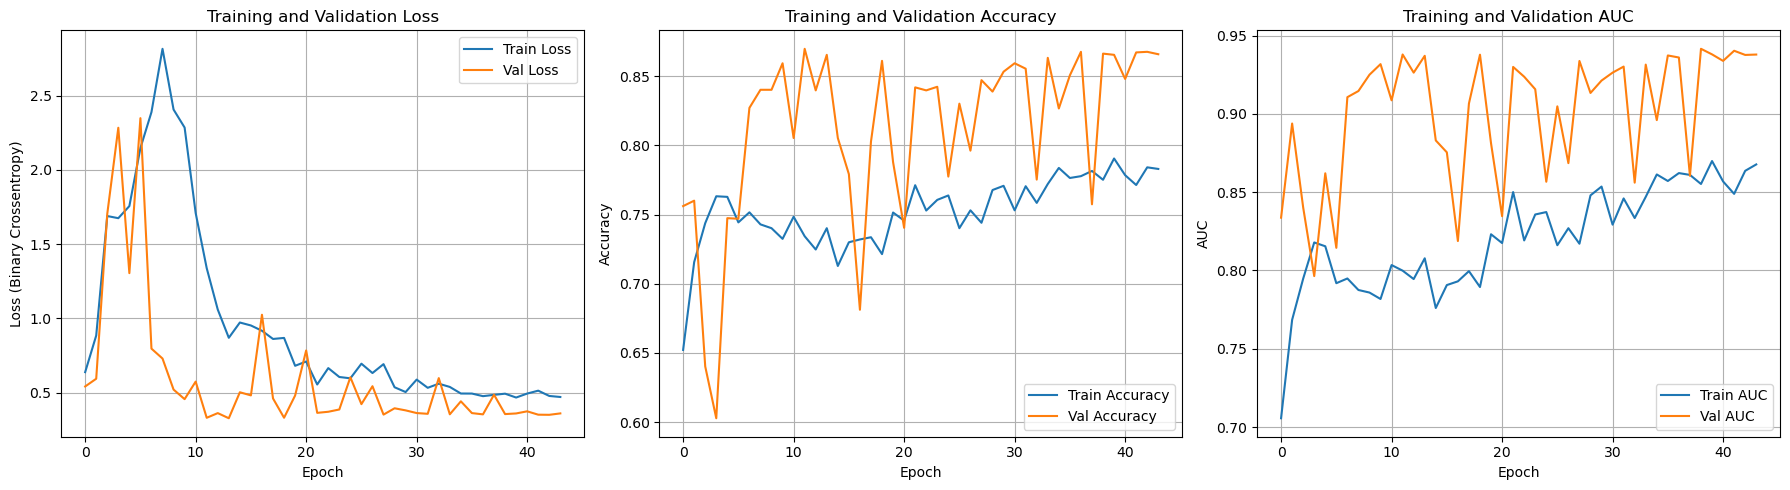

In [29]:
# ===== 7) 학습 곡선 시각화 =====
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Binary Crossentropy)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# AUC
axes[2].plot(history.history['auc'], label='Train AUC')
axes[2].plot(history.history['val_auc'], label='Val AUC')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Training and Validation AUC')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [30]:
# ===== 8) 모델 평가 (Validation) =====
val_loss, val_acc, val_auc = classifier.evaluate(X_val_scaled, y_val, verbose=0)

print("===== Validation 세트 평가 결과 =====")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"AUC: {val_auc:.4f}")

# 예측
pred_val = classifier.predict(X_val_scaled, verbose=0)
pred_val_binary = (pred_val > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_val, pred_val_binary, target_names=['Phishing', 'Legitimate']))

===== Validation 세트 평가 결과 =====
Loss: 0.3274
Accuracy: 0.8654
AUC: 0.9371

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.86      0.87      0.87      1148
  Legitimate       0.87      0.86      0.86      1148

    accuracy                           0.87      2296
   macro avg       0.87      0.87      0.87      2296
weighted avg       0.87      0.87      0.87      2296


Classification Report:
              precision    recall  f1-score   support

    Phishing       0.86      0.87      0.87      1148
  Legitimate       0.87      0.86      0.86      1148

    accuracy                           0.87      2296
   macro avg       0.87      0.87      0.87      2296
weighted avg       0.87      0.87      0.87      2296



In [31]:
# ===== 9) 모델 평가 (Test) =====
test_loss, test_acc, test_auc = classifier.evaluate(X_test_scaled, y_test, verbose=0)

print("===== Test 세트 평가 결과 =====")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"AUC: {test_auc:.4f}")

# 예측
pred_test = classifier.predict(X_test_scaled, verbose=0)
pred_test_binary = (pred_test > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_test, pred_test_binary, target_names=['Phishing', 'Legitimate']))

===== Test 세트 평가 결과 =====
Loss: 0.3348
Accuracy: 0.8659
AUC: 0.9387

Classification Report:
              precision    recall  f1-score   support

    Phishing       0.87      0.86      0.87      1148
  Legitimate       0.86      0.87      0.87      1149

    accuracy                           0.87      2297
   macro avg       0.87      0.87      0.87      2297
weighted avg       0.87      0.87      0.87      2297



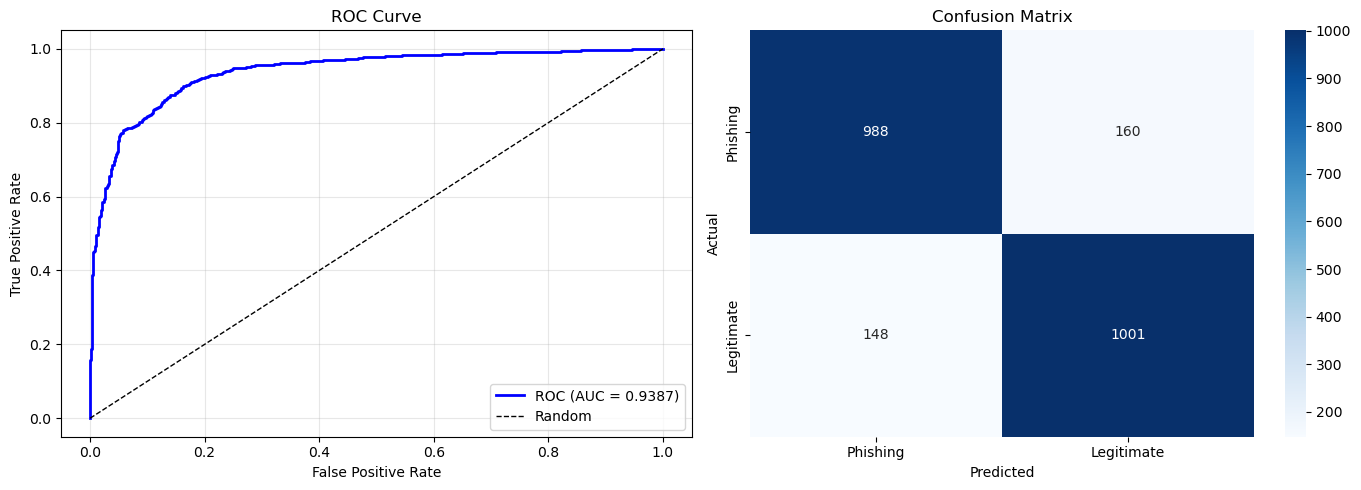

In [32]:
# ===== 10) ROC 커브 및 Confusion Matrix 시각화 =====
from sklearn.metrics import roc_curve, confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_test)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_test_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Phishing', 'Legitimate'],
            yticklabels=['Phishing', 'Legitimate'])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

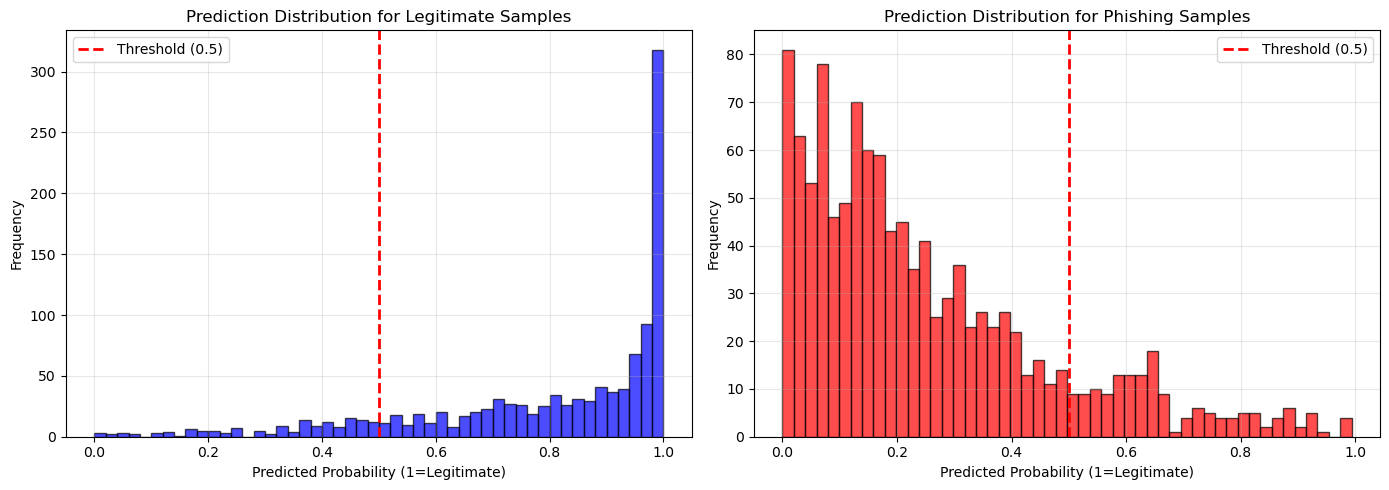


정상 사이트 평균 예측값: 0.7998
피싱 사이트 평균 예측값: 0.2504


In [33]:
# ===== 11) 예측 확률 분포 시각화 =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

legit_mask = (y_test == 1)
phish_mask = (y_test == 0)

# 정상 사이트의 예측 확률 분포
axes[0].hist(pred_test[legit_mask], bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[0].set_xlabel('Predicted Probability (1=Legitimate)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution for Legitimate Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 피싱 사이트의 예측 확률 분포
axes[1].hist(pred_test[phish_mask], bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability (1=Legitimate)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Prediction Distribution for Phishing Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n정상 사이트 평균 예측값: {pred_test[legit_mask].mean():.4f}")
print(f"피싱 사이트 평균 예측값: {pred_test[phish_mask].mean():.4f}")

t-SNE 변환 중...


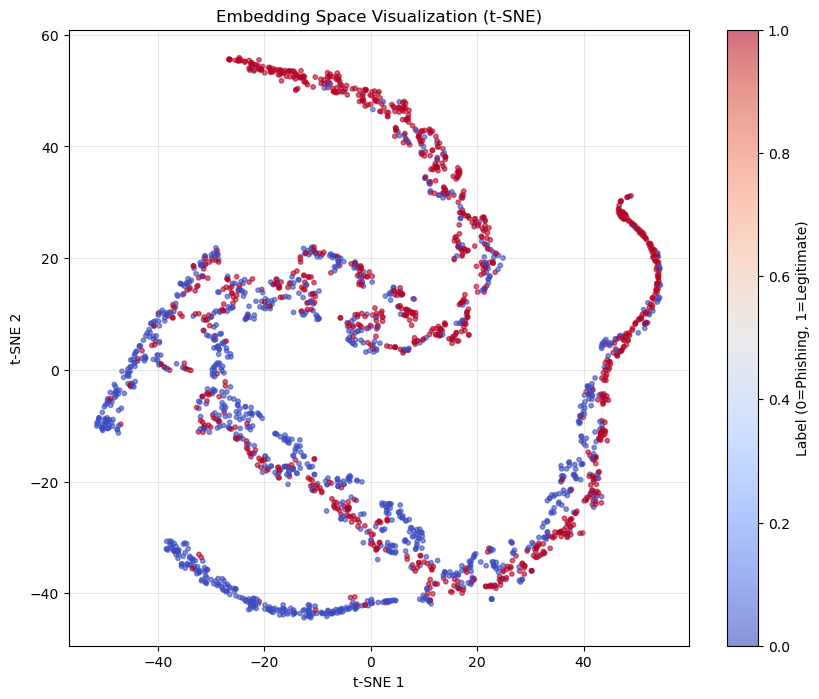

In [34]:
# ===== 12) 임베딩 공간 시각화 (t-SNE) =====
from sklearn.manifold import TSNE

# Encoder로 임베딩 추출
embeddings_test = encoder.predict(X_test_scaled, verbose=0)

# t-SNE 변환 (2D)
print("t-SNE 변환 중...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_test)

# 시각화
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Label (0=Phishing, 1=Legitimate)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Embedding Space Visualization (t-SNE)')
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
# ===== 13) 모델 저장 및 TFLite 변환 =====
# ⭐ from_keras_model 직접 변환 (가장 정확함)
# 주의: Apple Silicon에서 커널 크래시 발생 시 아래 대안 사용

import os
import gc

# 메모리 정리 (크래시 방지)
gc.collect()

OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "classifier_model.h5")
TFLITE_PATH = os.path.join(OUTPUT_DIR, "phishing_classifier.tflite")

# 1) Keras 모델 저장 (백업용)
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("✅ H5 모델 저장 완료!")

# 2) ⭐ Keras 모델에서 직접 TFLite 변환 (가장 정확)
print("\n" + "=" * 60)
print("🔧 TFLite 변환: from_keras_model 직접 변환")
print("=" * 60)

converter = tf.lite.TFLiteConverter.from_keras_model(classifier)

# 최적화/양자화 비활성화 (정확도 우선)
converter.optimizations = []
converter.target_spec.supported_types = [tf.float32]

tflite_model = converter.convert()

with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 3) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"입력 dtype: {input_details[0]['dtype']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Classifier 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_model.h5
✅ H5 모델 저장 완료!

🔧 TFLite 변환: from_keras_model 직접 변환


/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpemyc61sj/assets


INFO:tensorflow:Assets written to: /var/folders/nv/tfw2zdqs7031dn83bb91bwdr0000gn/T/tmpemyc61sj/assets


✅ TFLite 모델 저장 완료: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_classifier.tflite
📦 모델 크기: 86.93 KB

입력 shape: [ 1 71]
입력 dtype: <class 'numpy.float32'>
출력 shape: [1 1]
✅ TFLite 모델 검증 완료!


Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 12, Total Ops 22, % non-converted = 54.55 %
 * 12 ARITH ops

- arith.constant:   12 occurrences  (f32: 12)



  (f32: 6)
  (f32: 1)


In [1]:
import os
import tensorflow as tf

OUTPUT_DIR = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing"
CLASSIFIER_PATH = os.path.join(OUTPUT_DIR, "classifier_model.h5")
TFLITE_PATH     = os.path.join(OUTPUT_DIR, "phishing_classifier.tflite")

# 1) Keras 모델 저장 (있어도 되고 없어도 됨 – 디버깅용)
print(f"Classifier 모델 저장 중: {CLASSIFIER_PATH}")
classifier.save(CLASSIFIER_PATH)
print("H5 모델 저장 완료!")

# 2) Keras 모델에서 바로 TFLite 변환 (★ 핵심)
print("TFLite 변환 중 (from_keras_model)...")
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)

# 디버깅 단계에서는 최적화/양자화 옵션 다 끄기
# converter.optimizations = []
# converter.target_spec.supported_types = [tf.float32]

tflite_model = converter.convert()

with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ TFLite 모델 저장 완료: {TFLITE_PATH}")
print(f"📦 모델 크기: {len(tflite_model) / 1024:.2f} KB")

# 3) TFLite 모델 검증
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(f"\n입력 shape: {input_details[0]['shape']}")
print(f"출력 shape: {output_details[0]['shape']}")
print("✅ TFLite 모델 검증 완료!")

Classifier 모델 저장 중: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/classifier_model.h5


NameError: name 'classifier' is not defined

## 🔧 TFLite 변환 문제 해결: from_keras_model 직접 변환

**문제 원인:**
- `classifier.export()` → `from_saved_model()` 방식은 Keras 3에서 BatchNormalization의 `moving_mean/variance`가 제대로 전달되지 않을 수 있음
- TFLite 출력이 ~0.5로 수렴하는 것은 BatchNorm이 "학습 모드"처럼 동작하거나 통계가 손실된 증거

**해결책:**
- `tf.lite.TFLiteConverter.from_keras_model(classifier)`로 직접 변환
- SavedModel 중간 단계를 거치지 않아 BatchNorm 통계가 정확히 유지됨

In [36]:
# ===== 14) TFLite 모델 테스트 =====
import numpy as np
import tensorflow as tf

# ⭐ 중요: TFLite 파일을 새로 로드 (이전 interpreter 재사용 방지)
TFLITE_PATH = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_classifier.tflite"

print(f"TFLite 모델 로드: {TFLITE_PATH}")
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f"입력 shape: {input_details[0]['shape']}")
print(f"입력 dtype: {input_details[0]['dtype']}")
print(f"출력 shape: {output_details[0]['shape']}")

# 테스트 샘플 준비
test_sample = X_test_scaled[0:10].astype(np.float32)
batch_size = test_sample.shape[0]

# TFLite는 보통 [1, input_dim] 형태이므로 샘플별로 추론
print(f"\n샘플 {batch_size}개에 대해 추론 수행...")

tflite_outputs = []
for i in range(batch_size):
    sample = test_sample[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_outputs.append(output[0][0])

tflite_output = np.array(tflite_outputs).reshape(-1, 1)

# Keras 모델 추론
keras_output = classifier.predict(test_sample, verbose=0)

# 결과 비교
print("\n" + "=" * 60)
print("===== TFLite vs Keras 출력 비교 =====")
print("=" * 60)

for i in range(batch_size):
    actual = "정상" if y_test[i] == 1 else "피싱"
    diff = abs(tflite_output[i][0] - keras_output[i][0])
    match = "✅" if diff < 0.01 else "❌"
    print(f"샘플 {i+1}: TFLite={tflite_output[i][0]:.6f}, Keras={keras_output[i][0]:.6f}, 차이={diff:.6f} {match}, 실제={actual}")

# 통계
mae = np.mean(np.abs(tflite_output - keras_output))
max_err = np.max(np.abs(tflite_output - keras_output))
print(f"\n📊 통계:")
print(f"   평균 절대 오차 (MAE): {mae:.6f}")
print(f"   최대 오차: {max_err:.6f}")

if max_err < 0.001:
    print("\n🎉 TFLite와 Keras 출력이 거의 동일합니다! (오차 < 0.001)")
elif max_err < 0.01:
    print("\n✅ TFLite와 Keras 출력이 매우 유사합니다. (오차 < 0.01)")
else:
    print(f"\n⚠️ TFLite와 Keras 출력에 차이가 있습니다. (최대 오차: {max_err:.4f})")
    print("   → 모델을 다시 변환하거나, 커널을 재시작 후 처음부터 실행해보세요.")

TFLite 모델 로드: /Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/phishing/phishing_classifier.tflite
입력 shape: [ 1 71]
입력 dtype: <class 'numpy.float32'>
출력 shape: [1 1]

샘플 10개에 대해 추론 수행...

===== TFLite vs Keras 출력 비교 =====
샘플 1: TFLite=0.510412, Keras=0.136176, 차이=0.374236 ❌, 실제=피싱
샘플 2: TFLite=0.563598, Keras=0.983522, 차이=0.419924 ❌, 실제=정상
샘플 3: TFLite=0.606368, Keras=0.019097, 차이=0.587271 ❌, 실제=피싱
샘플 4: TFLite=0.593812, Keras=0.973178, 차이=0.379366 ❌, 실제=정상
샘플 5: TFLite=0.655744, Keras=0.418963, 차이=0.236780 ❌, 실제=피싱
샘플 6: TFLite=0.460354, Keras=0.742403, 차이=0.282049 ❌, 실제=정상
샘플 7: TFLite=0.575760, Keras=0.438102, 차이=0.137659 ❌, 실제=피싱
샘플 8: TFLite=0.659725, Keras=0.789934, 차이=0.130209 ❌, 실제=정상
샘플 9: TFLite=0.608187, Keras=0.302381, 차이=0.305806 ❌, 실제=피싱
샘플 10: TFLite=0.645206, Keras=0.658386, 차이=0.013180 ❌, 실제=정상

📊 통계:
   평균 절대 오차 (MAE): 0.286648
   최대 오차: 0.587271

⚠️ TFLite와 Keras 출력에 차이가 있습니다. (최대 오차: 0.5873)
   → 모델을 다시 변환하거나, 커널을 재시작 후 처음부터 실행해보세요.


In [ ]:
# ===== 15) Android assets 폴더로 복사 =====
import shutil

ANDROID_ASSETS = "/Users/seungmin/AndroidStudioProjects/YU_mobile_kotlin/app/src/main/assets"

# TFLite 모델 복사
shutil.copy(TFLITE_PATH, os.path.join(ANDROID_ASSETS, "phishing_classifier.tflite"))

print("✅ Android assets 폴더로 복사 완료!")
print(f"   {os.path.join(ANDROID_ASSETS, 'phishing_classifier.tflite')}")

# 최종 요약
print("\n" + "="*60)
print("✅ 피싱 분류 모델 생성 완료")
print("="*60)
print(f"\n📊 성능:")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Test AUC: {test_auc:.4f}")
print(f"\n📁 저장된 파일:")
print(f"   - phishing_classifier.tflite ({len(tflite_model) / 1024:.1f} KB)")
print(f"\n📱 Android 사용법:")
print("   - 입력: 21개 피처 (float32, -1/0/1 값)")
print("   - 출력: 1개 값 (0.0~1.0)")
print("   - 해석: 0.0 = 피싱, 1.0 = 정상")
print("   - 피싱 확률 = (1 - output) * 100%")
print("="*60)

## ✅ H5 / SavedModel vs In-memory 모델 일치성 검사

- 이 셀은 학습된 `classifier`(메모리), H5(`CLASSIFIER_PATH`) 및 SavedModel(`SAVED_MODEL_PATH`)을 불러와 같은 입력에 대해 예측값과 레이어별 가중치(Weights)를 비교합니다.
- `MAE`와 `max_abs_diff`, `class_match_rate`(기본 0.5 threshold)로 간단한 차이 메트릭을 확인합니다.

주의: `tf.keras.models.load_model(SAVED_MODEL_PATH)`가 실패할 경우 `tf.saved_model.load`로 로드해보세요.

In [17]:
# ===== H5 / SavedModel vs In-memory 모델 일치성 검사 코드 =====
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# 전달되어야 할 변수: classifier, CLASSIFIER_PATH, SAVED_MODEL_PATH, X_test_scaled
print('변수 확인: classifier, CLASSIFIER_PATH, SAVED_MODEL_PATH, X_test_scaled')

missing = []
for v in ['classifier', 'CLASSIFIER_PATH', 'SAVED_MODEL_PATH', 'X_test_scaled']:
    if v not in globals():
        missing.append(v)
if missing:
    raise RuntimeError(f'필요 변수/경로가 누락되었습니다: {missing} - 먼저 변수 선언된 셀들을 실행하세요.')

n = min(128, len(X_test_scaled))
sample = X_test_scaled[:n].astype(np.float32)

def predict_and_metrics(model, name):
    try:
        pred = model.predict(sample, batch_size=32, verbose=0).flatten()
        return pred
    except Exception as e:
        print(f'⚠️ {name} prediction error:', e)
        return None

# 1) 메모리상의 classifier 예측
print('\n-- 1) In-memory classifier 예측 --')
pred_mem = predict_and_metrics(classifier, 'in-memory')

# 2) H5에서 불러온 모델
pred_h5 = None
try:
    print('\n-- 2) H5 로드 및 예측 --')
    h5 = load_model(CLASSIFIER_PATH)
    pred_h5 = predict_and_metrics(h5, 'h5')
    print('H5 load OK')
except Exception as e:
    print('⚠️ H5 load error:', e)
    h5 = None

# 3) SavedModel 로드 및 예측
pred_saved = None
try:
    print('\n-- 3) SavedModel 로드 및 예측 --')
    saved = load_model(SAVED_MODEL_PATH)
    pred_saved = predict_and_metrics(saved, 'saved_model')
    print('SavedModel load OK')
except Exception as e:
    print('⚠️ SavedModel load error with load_model; trying tf.saved_model.load (lower level):', e)
    try:
        saved_low = tf.saved_model.load(SAVED_MODEL_PATH)
        print('Loaded with tf.saved_model.load; note this is not a Keras Model object.')
        saved = None
        pred_saved = None
    except Exception as e2:
        print('⚠️ SavedModel load low-level also failed:', e2)
        saved = None

def compare_preds(a, b, label_a, label_b):
    if a is None or b is None:
        print(f'🔍 {label_a} or {label_b} predictions missing; skipping comparison')
        return
    mae = mean_absolute_error(a, b)
    max_err = np.max(np.abs(a - b))
    match_rate = np.mean(((a > 0.5) == (b > 0.5)).astype(float))
    print(f'--- Compare {label_a} vs {label_b} ---')
    print(f'  MAE={mae:.6f}, MaxErr={max_err:.6f}, class_match_rate={match_rate:.6f}')

compare_preds(pred_mem, pred_h5, 'in-memory', 'h5')
compare_preds(pred_mem, pred_saved, 'in-memory', 'saved_model')
compare_preds(pred_h5, pred_saved, 'h5', 'saved_model')

# 레이어별 가중치(Weights) 비교
def compare_weights(model_a, model_b, name_a='A', name_b='B'):
    if model_a is None or model_b is None:
        print(f'🔍 {name_a} or {name_b} is None; skipping weights comparison')
        return
    try:
        layers_a = [l for l in model_a.layers if l.get_weights()]
        layers_b = [l for l in model_b.layers if l.get_weights()]
        if len(layers_a) != len(layers_b):
            print(f'⚠️ Layer count mismatch: {name_a}({len(layers_a)}) vs {name_b}({len(layers_b)})')
        pairs = min(len(layers_a), len(layers_b))
        print(f'--- Layer-wise weight diff {name_a} vs {name_b} ---')
        for i in range(pairs):
            wa = layers_a[i].get_weights()
            wb = layers_b[i].get_weights()
            if len(wa) != len(wb):
                print(f'  ⚠️ Layer {i} weight count mismatch: {len(wa)} vs {len(wb)} (layer_a={layers_a[i].name}, layer_b={layers_b[i].name})')
                continue
            # per-weight array diff
            for j, (w1, w2) in enumerate(zip(wa, wb)):
                if w1.shape != w2.shape:
                    print(f'  ⚠️ Layer {i} weight[{j}] shape mismatch: {w1.shape} vs {w2.shape} (layer_a={layers_a[i].name}, layer_b={layers_b[i].name})')
                else:
                    diff = np.max(np.abs(w1 - w2))
                    if diff > 1e-6:
                        print(f'  Layer {i} ({layers_a[i].name}) weight[{j}] max_abs_diff: {diff:.8f}')
        print('--- layer-wise comparison completed ---')
    except Exception as e:
        print('⚠️ error during weights comparison:', e)

compare_weights(classifier, h5, 'in-memory', 'h5')
compare_weights(classifier, saved if 'saved' in globals() and saved else None, 'in-memory', 'saved_model')

# 샘플 몇 개씩 값을 출력해보기 (선택)
def print_sample_diffs(mem, h5m, sm):
    n_show = min(10, len(sample))
    print('\n---- Sample predictions (first n) ----')
    for i in range(n_show):
        s_mem = mem[i] if mem is not None else None
        s_h5 = h5m[i] if h5m is not None else None
        s_sm = sm[i] if sm is not None else None
        print(f'{i}: mem={s_mem:.6f}', f'h5={s_h5:.6f}' if s_h5 is not None else '', f'saved={s_sm:.6f}' if s_sm is not None else '')

print_sample_diffs(pred_mem, pred_h5, pred_saved)

# 결과 해석 가이드
print('\n=== 결과 해석 가이드 ===')
print(' - MAE < 1e-6: 사실상 동일')
print(' - MaxErr 정도가 1e-3 이하: floating point 차이 수준')
print(' - MaxErr 1e-2 이상 혹은 class_match_rate < 0.99: 차이 원인 파악 필요 (저장/불러오기/버전/형식/quantization 등)')
print(' - 레이어 가중치 차이가 있으면 모델 저장시 weight가 제대로 기록되지 않았을 가능성, 또는 Keras 버전 문제 등 버전 불일치가 의심됩니다.')

print('\n검사 완료.')

변수 확인: classifier, CLASSIFIER_PATH, SAVED_MODEL_PATH, X_test_scaled


RuntimeError: 필요 변수/경로가 누락되었습니다: ['SAVED_MODEL_PATH'] - 먼저 변수 선언된 셀들을 실행하세요.

## 🔧 SavedModel 재저장 및 tf.saved_model.load() 검증 (옵션 B)

- 목적: legacy SavedModel 포맷으로 인해 Keras 3에서 load_model()이 실패하므로, `tf.saved_model.save`를 이용해 재저장한 후 `tf.saved_model.load`로 서명을 호출해 예측값을 비교합니다.
- 동작: 기존 SavedModel이 있으면 백업하고 새로 저장, load 및 `serving_default` 서명(또는 첫번째 서명)으로 예측 수행, Keras 메모리 모델과 값 비교

In [18]:
# ===== SavedModel 재저장 및 tf.saved_model.load() 검증 (옵션 B) =====
import os, shutil, numpy as np, tensorflow as tf

# 확인할 변수들
for v in ['classifier','SAVED_MODEL_PATH','OUTPUT_DIR','X_test_scaled']:
    if v not in globals():
        raise RuntimeError(f'Missing variable {v}. Run earlier cells to ensure these are defined.')

# 백업(이미 SavedModel 디렉토리가 존재하면 안전하게 이동)
if os.path.exists(SAVED_MODEL_PATH):
    backup_dir = SAVED_MODEL_PATH + '.bak'
    if os.path.exists(backup_dir):
        shutil.rmtree(backup_dir)
    shutil.move(SAVED_MODEL_PATH, backup_dir)
    print(f'Existing SavedModel moved to: {backup_dir}')

# 1) 재저장: tf.saved_model.save 사용 (legacy savedmodel 포맷으로 export)
print('Saving classifier as TF SavedModel (tf.saved_model.save) ->', SAVED_MODEL_PATH)
try:
    tf.saved_model.save(classifier, SAVED_MODEL_PATH)
    print('SavedModel export complete.')
except Exception as e:
    print('⚠️ tf.saved_model.save failed:', e)

# 2) 로드 및 서명 확인

saved = tf.saved_model.load(SAVED_MODEL_PATH)
signatures = list(saved.signatures.keys())
print('Available signatures:', signatures)
sig_key = 'serving_default' if 'serving_default' in signatures else (signatures[0] if signatures else None)
if sig_key is None:
    raise RuntimeError('No signatures found in SavedModel; cannot infer with signature')
print('Using signature:', sig_key)
infer = saved.signatures[sig_key]
print('Structured input signature:', infer.structured_input_signature)

# 3) infer 호출 및 비교 (sig dict / positional handling)
n = min(128, len(X_test_scaled))
sample = X_test_scaled[:n].astype(np.float32)

def call_saved_infer(infer_fn, arr):
    import tensorflow as _tf
    sig = infer_fn.structured_input_signature[1]
    arr_tf = _tf.constant(arr)
    out = None
    try:
        if isinstance(sig, dict) and len(sig) > 0:
            key = list(sig.keys())[0]
            out = infer_fn(**{key: arr_tf})
        else:
            out = infer_fn(arr_tf)
    except Exception as ex:
        # Try calling with dict key=None fallback
        print('⚠️ infer call failed with signature style; trying dict with first key:', ex)
        if isinstance(sig, dict) and len(sig) > 0:
            key = list(sig.keys())[0]
            out = infer_fn(**{key: arr_tf})
        else:
            raise
    return out

out = call_saved_infer(infer, sample)
# extract numpy vector (dict or tensor)
if isinstance(out, dict):
    out_val = list(out.values())[0].numpy().reshape(-1)
else:
    out_val = out.numpy().reshape(-1)

# 4) Keras 메모리 모델과 비교
pred_mem = classifier.predict(sample, verbose=0).flatten()
mae = np.mean(np.abs(pred_mem - out_val))
max_err = np.max(np.abs(pred_mem - out_val))
class_match_rate = np.mean(((pred_mem > 0.5) == (out_val > 0.5)).astype(float))
print('== SavedModel (tf.saved_model.load) vs In-memory Keras ==')
print(f'MAE={mae:.6f}, MaxErr={max_err:.6f}, class_match_rate={class_match_rate:.6f}')

# 샘플 일부 출력
print('Sample comparisons (first 10):')
for i in range(min(10, len(sample))):
    print(i, f'mem={pred_mem[i]:.6f}', f'saved={out_val[i]:.6f}')

# 5) 필요 시 TFLite 변환 다시 수행(from_saved_model) 및 비교 - optional
print('If you want, re-run TFLite conversion from this SavedModel and compare Keras vs TFLite (use previous conversion cells)')
print('Done.')

RuntimeError: Missing variable SAVED_MODEL_PATH. Run earlier cells to ensure these are defined.